In [1]:
import wikipedia, requests, random, pycm, json, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from tqdm import tqdm
from IPython.display import display, Markdown
from classification_procedure import ClassificationProcedure

## Classification procedures

In [2]:
oed_woman = ClassificationProcedure(
    "OED",
    "woman", 
    """An adult female human being. The counterpart of man (see man, n.¹ II.4.)""",
    "https://www.oed.com/dictionary/woman_n"
)

haslanger_woman = ClassificationProcedure(
    "Haslanger",
    "woman", 
    """S is a woman iff (i) S is regularly and for the most part observed or imagined to have 
certain bodily features presumed to be evidence of a female’s biological role in reproduction; 
(ii) that S has these features marks S within the dominant ideology of S’s society as someone who 
ought to occupy certain kinds of social position that are in fact subordinate (and so motivates 
and justifies S’s occupying such a position); and (iii) the fact that S satisfies (I) and (ii) plays 
a role in S’s systematic subordination, that is, along some dimension, S’s social position is oppressive, 
and S’s satisfying (i) and (ii) plays a role in that dimension of subordination""",
    "https://www.jstor.org/stable/2671972"
)

homosaurus_women = ClassificationProcedure(
    "Homosaurus",
    "woman", 
    """Adults who self-identify as women and understand their gender in terms of 
Western conceptions of womanness, femaleness, and/or femininity. The term has typically 
been defined as adult female humans, though not all women identify with the term 'female' 
depending on the context in which it is used.""",
    "https://homosaurus.org/v3/homoit0001509"
)

## Wikidata queries

In [3]:
KNOWLEDGE_GRAPH = "https://query.wikidata.org/sparql"

QUERY_HEADERS = {
    'User-Agent': 'ConceptualEngineeringAgent/0.2 (https://github.com/bradleypallen/conceptual-engineering-using-llms; b.p.allen@uva.nl)',
}

SAMPLE_SIZE = 50

POSITIVE_EXAMPLES_QUERY = """SELECT DISTINCT ?entity ?name ?article WHERE {
  {
    ?entity wdt:P21 wd:Q6581072 .
    ?article schema:about ?entity ;
            schema:inLanguage "en" ;
            schema:isPartOf <https://en.wikipedia.org/> ;
            schema:name ?name .
    wd:Q6581072 rdfs:label ?gender .
    FILTER (lang(?gender) = "en")
  }
  UNION
  {
    ?entity wdt:P21 wd:Q1052281 .
    ?article schema:about ?entity ;
           schema:inLanguage "en" ;
           schema:isPartOf <https://en.wikipedia.org/> ;
           schema:name ?name .
    wd:Q1052281 rdfs:label ?gender .
    FILTER (lang(?gender) = "en")
  }
} LIMIT 10000"""

NEGATIVE_EXAMPLES_QUERY = """SELECT DISTINCT ?entity ?name ?article WHERE {
  {
    ?entity wdt:P21 wd:Q6581097 .
    ?article schema:about ?entity ;
            schema:inLanguage "en" ;
            schema:isPartOf <https://en.wikipedia.org/> ;
            schema:name ?name .
    wd:Q6581097 rdfs:label ?gender .
    FILTER (lang(?gender) = "en")
  }
  UNION
  {
    ?entity wdt:P21 wd:Q48270 .
    ?article schema:about ?entity ;
           schema:inLanguage "en" ;
           schema:isPartOf <https://en.wikipedia.org/> ;
           schema:name ?name .
    wd:Q48270 rdfs:label ?gender .
    FILTER (lang(?gender) = "en")
  }
  UNION
  {
    ?entity wdt:P21 wd:Q2449503 .
    ?article schema:about ?entity ;
           schema:inLanguage "en" ;
           schema:isPartOf <https://en.wikipedia.org/> ;
           schema:name ?name .
    wd:Q2449503 rdfs:label ?gender .
    FILTER (lang(?gender) = "en")
 }
} LIMIT 10000"""

## Example entities

In [4]:
response = requests.get(KNOWLEDGE_GRAPH, params={'query' : POSITIVE_EXAMPLES_QUERY, 'format' : 'json'}, headers=QUERY_HEADERS)
response.raise_for_status()
json_response = response.json()
records = [ [ result["entity"]["value"], result["name"]["value"], result["article"]["value"] ] for result in json_response["results"]["bindings"] ]
records = random.sample(records, SAMPLE_SIZE)
positive_examples = pd.DataFrame.from_records(records, columns=["id", "name", "article"])
positive_examples["description"] = positive_examples["name"].apply(lambda name: wikipedia.summary(name, auto_suggest=False).replace('"', r'\"').strip()) 
positive_examples["actual"] = "positive"

In [5]:
response = requests.get(KNOWLEDGE_GRAPH, params={'query' : NEGATIVE_EXAMPLES_QUERY, 'format' : 'json'}, headers=QUERY_HEADERS)
response.raise_for_status()
json_response = response.json()
records = [ [ result["entity"]["value"], result["name"]["value"], result["article"]["value"] ] for result in json_response["results"]["bindings"] ]
records = random.sample(records, SAMPLE_SIZE)
negative_examples = pd.DataFrame.from_records(records, columns=["id", "name", "article"])
negative_examples["description"] = negative_examples["name"].apply(lambda name: wikipedia.summary(name, auto_suggest=False).replace('"', r'\"').strip()) 
negative_examples["actual"] = "negative"

In [6]:
examples = pd.concat([positive_examples, negative_examples], ignore_index=True)
examples

,id,name,article,description,actual
0,http://www.wikidata.org/entity/Q78364,Sigrid Onégin,https://en.wikipedia.org/wiki/Sigrid_On%C3%A9gin,"Sigrid Onégin (June 1, 1889 – June 16, 1943) w...",positive
1,http://www.wikidata.org/entity/Q214617,Hagar,https://en.wikipedia.org/wiki/Hagar,"According to the Book of Genesis, Hagar was an...",positive
2,http://www.wikidata.org/entity/Q100206,Mechtildis of Edelstetten,https://en.wikipedia.org/wiki/Mechtildis_of_Ed...,"Mechtildis of Edelstetten, also known as Mecht...",positive
3,http://www.wikidata.org/entity/Q77765,Juliane Werding,https://en.wikipedia.org/wiki/Juliane_Werding,Juliane Werding (born 19 July 1956 in Essen) i...,positive
4,http://www.wikidata.org/entity/Q111188,Hannah Vogt,https://en.wikipedia.org/wiki/Hannah_Vogt,"Hannah Vogt (3 March 1910, Berlin – 13 Februar...",positive
...,...,...,...,...,...
95,http://www.wikidata.org/entity/Q29664,Narendra Karmarkar,https://en.wikipedia.org/wiki/Narendra_Karmarkar,Narendra Krishna Karmarkar (born circa 1956) i...,negative
96,http://www.wikidata.org/entity/Q23437,William Hirstein,https://en.wikipedia.org/wiki/William_Hirstein,William Hirstein is an American philosopher pr...,negative
97,http://www.wikidata.org/entity/Q6013,James Heneghan,https://en.wikipedia.org/wiki/James_Heneghan,James Heneghan (7 October 1930 – 23 April 2021...,negative
98,http://www.wikidata.org/entity/Q43067,Heinrich Himmler,https://en.wikipedia.org/wiki/Heinrich_Himmler,Heinrich Luitpold Himmler (German: [ˈhaɪnʁɪç ˈ...,negative


## Experiments

In [7]:
def run_experiment(cp, examples):
    classifications = examples.to_dict("records")
    for entity in tqdm(classifications):
        classification = cp.classify(entity["name"], entity["description"])
        entity["rationale"] = classification["rationale"]
        entity["predicted"] = classification["answer"]
    return pd.DataFrame.from_records(classifications)

In [9]:
oed_woman_results = run_experiment(oed_woman, examples)

100%|██████████| 100/100 [09:14<00:00,  5.54s/it]


In [10]:
haslanger_woman_results = run_experiment(haslanger_woman, examples)

100%|██████████| 100/100 [15:54<00:00,  9.54s/it]


In [11]:
homosaurus_women_results = run_experiment(homosaurus_women, examples)

100%|██████████| 100/100 [11:06<00:00,  6.67s/it]


## Performance metrics

In [12]:
oed_woman_cm = pycm.ConfusionMatrix(
    oed_woman_results["actual"].tolist(), 
    oed_woman_results["predicted"].tolist(), 
    digit=2, 
    classes=[ 'positive', 'negative' ]
)

haslanger_woman_cm = pycm.ConfusionMatrix(
    haslanger_woman_results["actual"].tolist(), 
    haslanger_woman_results["predicted"].tolist(), 
    digit=2, 
    classes=[ 'positive', 'negative' ]
)

homosaurus_women_cm = pycm.ConfusionMatrix(
    homosaurus_women_results["actual"].tolist(), 
    homosaurus_women_results["predicted"].tolist(), 
    digit=2, 
    classes=[ 'positive', 'negative' ]
)

In [13]:
cms = [
    (f'{oed_woman.term} ({oed_woman.id})', oed_woman_cm),
    (f'{haslanger_woman.term} ({haslanger_woman.id})', haslanger_woman_cm),
    (f'{homosaurus_women.term} ({homosaurus_women.id})', homosaurus_women_cm)
]

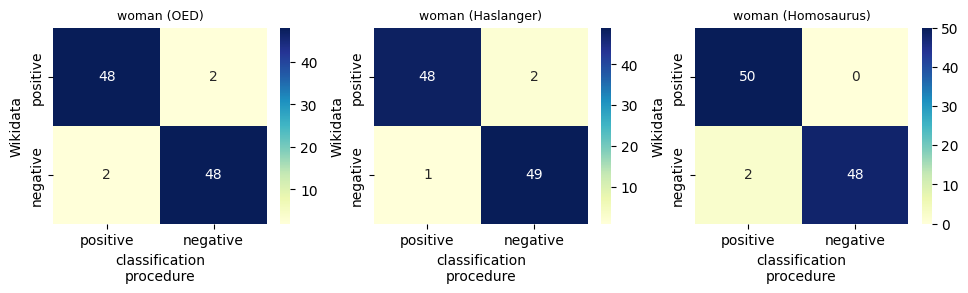

In [14]:
fig = plt.figure(figsize=(20,14))
gs = fig.add_gridspec(4, 5, hspace=0.5)
axes = gs.subplots()
for ax, (name, cm) in zip(axes.flat, cms):
    df = pd.DataFrame(cm.matrix).T.fillna(0)
    sns.heatmap(df, annot=True, fmt='d', cmap="YlGnBu", ax=ax)
    ax.set_title(name, wrap=True, fontsize=9)
    ax.set(xlabel='classification\nprocedure', ylabel='Wikidata')
for ax in axes.flat[len(cms):]:
    ax.set_visible(False)
plt.show()

In [15]:
metrics = pd.DataFrame.from_records([ 
    { "classification procedure": cm[0], "Cohen's kappa": cm[1].Kappa, "F1 macro": cm[1].F1_Macro, "FN": cm[1].FN["positive"], "FP": cm[1].FP["positive"] }
    for cm in cms 
])
metrics.sort_values(by="Cohen's kappa", ascending=False)

,classification procedure,Cohen's kappa,F1 macro,FN,FP
2,woman (Homosaurus),0.96,0.979992,0,2
1,woman (Haslanger),0.94,0.969997,2,1
0,woman (OED),0.92,0.960000,2,2


## Error analyses

In [16]:
def display_errors(cp, results):
    display(Markdown(f'### {cp.term} ({cp.id})'))
    display(Markdown(f'#### Definition'))
    display(Markdown(f'{cp.definition}'))
    fns = results[((results["actual"] == 'positive') & (results["predicted"] == 'negative'))][["name", "description", "rationale"]]
    if len(fns) > 0:
        fns_styler = fns.style.set_properties(**{"text-align": "left", "vertical-align" : "top", "overflow-wrap": "break-word"}).hide(axis="index")
        display(Markdown(f'#### False negatives'))
        display(fns_styler)
    fps = results[((results["actual"] == 'negative') & (results["predicted"] == 'positive'))][["name", "description", "rationale"]]
    if len(fps) > 0:
        fps_styler = fps.style.set_properties(**{"text-align": "left", "vertical-align" : "top", "overflow-wrap": "break-word"}).hide(axis="index")
        display(Markdown(f'#### False positives'))
        display(fps_styler)


In [17]:
display_errors(oed_woman, oed_woman_results)

### woman (OED)

#### Definition

An adult female human being. The counterpart of man (see man, n.¹ II.4.)

#### False negatives

name,description,rationale
Nemesis,"In ancient Greek religion, Nemesis, also called Rhamnousia or Rhamnusia (Ancient Greek: Ῥαμνουσία, romanized: Rhamnousía, lit. 'the goddess of Rhamnous'), was the goddess who personifies retribution for the sin of hubris: arrogance before the gods.","Nemesis is described as a goddess in ancient Greek religion. A goddess is a female deity, and since deities are often anthropomorphized or given human characteristics, it can be inferred that Nemesis, being a goddess, is a female. According to the provided definition, a woman is an adult female human being. Therefore, if we consider goddesses as female entities with human characteristics, it can be argued that Nemesis is a woman."
Brianna Ghey,"On 11 February 2023, Brianna Ghey ( JY), a 16-year-old British transgender girl from Birchwood in Warrington, Cheshire, England, was killed in Culcheth Linear Park in Culcheth, Warrington. Two accused teenagers, both aged 15, are in police custody, having been charged with murder four days after the incident. A motive has not been established and police are investigating \""all lines of inquiry\"", including investigating the killing as a possible hate crime.","Brianna Ghey is identified as a ""transgender girl"" in the description. The term ""transgender"" refers to individuals whose gender identity differs from the sex they were assigned at birth. In this case, Brianna Ghey, though biologically assigned a different sex at birth, identifies as a female. The concept of a woman, as defined above, refers to an ""adult female human being."" While Brianna Ghey is not an adult, she is a female human being by virtue of her gender identity. Therefore, it can be argued that Brianna Ghey is a woman, albeit a young one, based on her self-identified gender."


#### False positives

name,description,rationale
Michelle Rojas,"Michelle Rojas (née Pennington; born December 16, 1987) is an American voice actress from Dallas, Texas. Affiliated with Funimation and Bang Zoom! Entertainment, some of her major roles are Tohka Yatogami in Date A Live, Zuikaku in Azur Lane, Kanade Sakurada in Castle Town Dandelion, Mikoto Sakuragawa in Gonna be the Twin-Tail!!, Kō Yagami in New Game!, Nashiro Yasuhisa in Tokyo Ghoul, Maya Sato in Classroom of the Elite, Toka Yada in Assassination Classroom, Shion in That Time I Got Reincarnated as a Slime, Roxy Migurdia in Mushoku Tensei: Jobless Reincarnation, and Yamato in One Piece.","The definition provided states that a woman is an adult female human being. The description of Michelle Rojas identifies her as a female, as indicated by the use of female pronouns. Additionally, her birth date is given as December 16, 1987, which makes her an adult. Therefore, based on the definition provided, Michelle Rojas can be classified as a woman."
Linden A. Lewis,"Linden A. Lewis is a science fiction author, best known for their debut novel The First Sister. Lewis is queer and uses she/they pronouns.","The definition provided for ""woman"" is an adult female human being. Linden A. Lewis is identified with the use of she/they pronouns, which suggests that Lewis identifies, at least in part, as female. As Lewis is an adult human being, and part of their identity aligns with being female, it can be argued, based on the given definition, that Linden A. Lewis is a woman."


In [18]:
display_errors(haslanger_woman, haslanger_woman_results)

### woman (Haslanger)

#### Definition

S is a woman iff (i) S is regularly and for the most part observed or imagined to have 
certain bodily features presumed to be evidence of a female’s biological role in reproduction; 
(ii) that S has these features marks S within the dominant ideology of S’s society as someone who 
ought to occupy certain kinds of social position that are in fact subordinate (and so motivates 
and justifies S’s occupying such a position); and (iii) the fact that S satisfies (I) and (ii) plays 
a role in S’s systematic subordination, that is, along some dimension, S’s social position is oppressive, 
and S’s satisfying (i) and (ii) plays a role in that dimension of subordination

#### False negatives

name,description,rationale
Waltraud Klasnic,"Waltraud Klasnic (née Tschiltsch, born 27 October 1945) is an Austrian politician who was Landeshauptfrau (governor) of Styria from 1996 until 2005.","The definition of a woman provided includes three main criteria: (i) having certain bodily features associated with the female biological role in reproduction, (ii) being marked within the dominant ideology of one's society as someone who should occupy certain subordinate social positions, and (iii) the fact that satisfying (i) and (ii) contributes to one's systematic subordination. In the case of Waltraud Klasnic, while the description does not explicitly state her biological features or her societal role, it does mention that she is an Austrian politician who served as the governor of Styria. This implies that she is recognized and accepted in a significant societal role, which suggests that she likely satisfies criteria (ii). However, the description does not provide enough information to definitively assert that Waltraud Klasnic satisfies all the criteria in the definition of a woman. For instance, it does not provide information about her biological features or whether she experiences systematic subordination due to her gender. Therefore, based solely on the provided definition and description, we cannot conclusively argue that Waltraud Klasnic is a woman."
Michaela Kirchgasser,"Michaela Kirchgasser (born 18 March 1985) is a retired Austrian alpine ski racer. She raced in the technical events of slalom and giant slalom, and also the combined.","The description of Michaela Kirchgasser does not provide any direct information about her bodily features or her social position in society. However, it does mention that she is referred to with the female pronoun ""she"", which suggests that she is observed or imagined to have certain bodily features presumed to be evidence of a female’s biological role in reproduction. This satisfies condition (i) of the definition. The description does not provide information about the dominant ideology of her society or her social position, so we cannot determine whether she satisfies condition (ii). Similarly, the description does not provide information about any systematic subordination or oppression she might face, so we cannot determine whether she satisfies condition (iii). Therefore, based on the limited information provided, we can only partially argue that Michaela Kirchgasser is a woman according to the given definition. More information would be needed to fully satisfy all conditions of the definition."


#### False positives

name,description,rationale
Michelle Rojas,"Michelle Rojas (née Pennington; born December 16, 1987) is an American voice actress from Dallas, Texas. Affiliated with Funimation and Bang Zoom! Entertainment, some of her major roles are Tohka Yatogami in Date A Live, Zuikaku in Azur Lane, Kanade Sakurada in Castle Town Dandelion, Mikoto Sakuragawa in Gonna be the Twin-Tail!!, Kō Yagami in New Game!, Nashiro Yasuhisa in Tokyo Ghoul, Maya Sato in Classroom of the Elite, Toka Yada in Assassination Classroom, Shion in That Time I Got Reincarnated as a Slime, Roxy Migurdia in Mushoku Tensei: Jobless Reincarnation, and Yamato in One Piece.","Based on the provided definition, we can infer that Michelle Rojas is a woman. The definition states that a woman is someone who is observed or imagined to have certain bodily features associated with the female biological role in reproduction. While the description does not explicitly state that Michelle Rojas has these features, it is implied by the use of female pronouns and her traditionally female first name. The definition also states that a woman is someone who, within the dominant ideology of their society, is expected to occupy certain social positions that are subordinate. While the description does not provide specific information about Michelle Rojas's social position, it is reasonable to infer that as a woman in American society, she may face certain societal expectations and potential subordination due to her gender. Lastly, the definition states that a woman is someone whose social position is oppressive along some dimension, and that their satisfying the first two conditions plays a role in this subordination. Again, while the description does not provide specific information about any oppression Michelle Rojas may face, it is reasonable to infer that as a woman in American society, she may face systemic gender-based oppression. Therefore, based on the provided definition and the information in the description, it is reasonable to assert that Michelle Rojas is a woman."


In [19]:
display_errors(homosaurus_women, homosaurus_women_results)

### woman (Homosaurus)

#### Definition

Adults who self-identify as women and understand their gender in terms of 
Western conceptions of womanness, femaleness, and/or femininity. The term has typically 
been defined as adult female humans, though not all women identify with the term 'female' 
depending on the context in which it is used.

#### False positives

name,description,rationale
Michelle Rojas,"Michelle Rojas (née Pennington; born December 16, 1987) is an American voice actress from Dallas, Texas. Affiliated with Funimation and Bang Zoom! Entertainment, some of her major roles are Tohka Yatogami in Date A Live, Zuikaku in Azur Lane, Kanade Sakurada in Castle Town Dandelion, Mikoto Sakuragawa in Gonna be the Twin-Tail!!, Kō Yagami in New Game!, Nashiro Yasuhisa in Tokyo Ghoul, Maya Sato in Classroom of the Elite, Toka Yada in Assassination Classroom, Shion in That Time I Got Reincarnated as a Slime, Roxy Migurdia in Mushoku Tensei: Jobless Reincarnation, and Yamato in One Piece.","The description of Michelle Rojas does not explicitly state her gender identity. However, it does use female pronouns (""her"") to refer to her, which typically aligns with a self-identification as a woman. Furthermore, she has taken on roles that are typically associated with women, such as female characters in various shows. Therefore, based on the information provided and the definition of a woman, it can be argued that Michelle Rojas is a woman."
Linden A. Lewis,"Linden A. Lewis is a science fiction author, best known for their debut novel The First Sister. Lewis is queer and uses she/they pronouns.","The definition of a woman includes adults who self-identify as women. Linden A. Lewis uses she/they pronouns, which indicates that they may identify as a woman. Therefore, based on the provided definition, it can be argued that Linden A. Lewis is a woman."


## Experimental results data dump

In [20]:
EXPERIMENTS_FILENAME = "woman_experiment.json"

experiments = [
    {
        "classification_procedure": {
            "id": cp.id,
            "term": cp.term,
            "definition": cp.definition,
            "reference": cp.reference,
            "model_name": cp.model_name,
            "temperature": cp.temperature
        },
        "results": results.to_dict("records")
    } for cp, results in [
        (oed_woman, oed_woman_results),
        (haslanger_woman, haslanger_woman_results),
        (homosaurus_women, homosaurus_women_results)
    ]
]

json.dump(experiments, open(EXPERIMENTS_FILENAME, 'w+'))